In [1]:
import sys
import copy
import math
import random
import datetime
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from PIL import Image
from tabulate import tabulate
from collections import defaultdict

sys.path.append('.')
sys.path.append('../../')

# Import dataset

In [2]:
csv_anon_file = pd.read_csv("./palinAnonimized.csv", dtype=str)
csv_anon_file

,date,userID,label
0,2009-07-03 19:59:33,0,questions
1,2009-07-04 01:37:35,1,questions
2,2009-07-05 01:20:02,2,unrelated
3,2009-07-19 06:06:50,3,unrelated
4,2009-07-05 13:52:12,2,unrelated
...,...,...,...
4418,2009-12-11 04:40:09,3181,unrelated
4419,2009-12-08 21:18:49,3182,endorses
4420,2009-12-30 17:16:58,3183,unrelated
4421,2009-12-09 09:05:08,3184,endorses


## Sort dataset

In [3]:
csv_anon_file.sort_values(by=['date'], inplace=True, ignore_index=True)
csv_anon_file

,date,userID,label
0,2009-07-03 19:59:33,0,questions
1,2009-07-04 01:37:35,1,questions
2,2009-07-05 01:20:02,2,unrelated
3,2009-07-05 13:52:12,2,unrelated
4,2009-07-19 06:06:50,3,unrelated
...,...,...,...
4418,2009-12-30 17:16:58,3183,unrelated
4419,2009-12-31 00:57:27,3174,unrelated
4420,2009-12-31 02:59:28,3175,unrelated
4421,2009-12-31 03:18:59,3179,unrelated


## Remove initial messages from non believers of fake news

In [4]:
# Individuazione dell'indice della prima riga con label "endorses" (se esiste)
first_endorser_index = csv_anon_file[csv_anon_file['label'] == 'endorses'].index.min()

In [5]:
# Verifica se è stata trovata una riga con label "endorses"
if first_endorser_index is not None:
    # Rimozione delle righe iniziali fino alla prima riga con label "endorses"
    csv_anon_file = csv_anon_file[first_endorser_index:].reset_index(drop=True)
else:
    # Nessuna riga con label "endorses" trovata, il dataset rimane inalterato
    pass

In [6]:
csv_anon_file

,date,userID,label
0,2009-08-01 16:17:03,18,endorses
1,2009-08-01 16:21:06,103,endorses
2,2009-08-01 16:43:49,1660,endorses
3,2009-08-01 16:56:23,1942,endorses
4,2009-08-01 17:03:04,2808,endorses
...,...,...,...
4411,2009-12-30 17:16:58,3183,unrelated
4412,2009-12-31 00:57:27,3174,unrelated
4413,2009-12-31 02:59:28,3175,unrelated
4414,2009-12-31 03:18:59,3179,unrelated


## Count the number of users in the dataset

In [7]:
users = csv_anon_file['userID'].unique()
users

array(['18', '103', '1660', ..., '3175', '3179', '3173'], dtype=object)

In [8]:
len(users)

3181

## Convert the time String in a DateTime object

In [9]:
csv_anon_file['date'] = pd.to_datetime(csv_anon_file['date'], format="%Y-%m-%d %H:%M:%S")

In [10]:
csv_anon_file['date'][0], csv_anon_file['date'][1]

(Timestamp('2009-08-01 16:17:03'), Timestamp('2009-08-01 16:21:06'))

## Find the first and last day of the dataset

In [11]:
first_day = csv_anon_file['date'].min()
print("Primo giorno:", first_day)

Primo giorno: 2009-08-01 16:17:03


In [12]:
last_day = csv_anon_file['date'].max()
print("Ultimo giorno:", last_day)

Ultimo giorno: 2009-12-31 03:19:12


## Definition of the epochs (days)

In [13]:
csv_anon_file['date'] = csv_anon_file['date'].dt.date
csv_anon_file

,date,userID,label
0,2009-08-01,18,endorses
1,2009-08-01,103,endorses
2,2009-08-01,1660,endorses
3,2009-08-01,1942,endorses
4,2009-08-01,2808,endorses
...,...,...,...
4411,2009-12-30,3183,unrelated
4412,2009-12-31,3174,unrelated
4413,2009-12-31,3175,unrelated
4414,2009-12-31,3179,unrelated


In [14]:
timesteps = []
timestep_number = 0
timesteps_column = []
timestep_start = pd.Timestamp(2000, 1, 1, 0)
timestep_start = timestep_start.strftime("%Y-%m-%d")
for i in range(len(csv_anon_file)):
    timestep_new = csv_anon_file['date'][i]
    timestep_new = timestep_new.strftime("%Y-%m-%d")
    if timestep_start != timestep_new:
        timestep_start = timestep_new
        timesteps.append(timestep_start)
        timestep_number += 1
    timesteps_column.append(timestep_number)

In [15]:
timesteps

['2009-08-01',
 '2009-08-02',
 '2009-08-03',
 '2009-08-04',
 '2009-08-05',
 '2009-08-06',
 '2009-08-07',
 '2009-08-08',
 '2009-08-09',
 '2009-08-10',
 '2009-08-11',
 '2009-08-12',
 '2009-08-13',
 '2009-08-14',
 '2009-08-15',
 '2009-08-16',
 '2009-08-17',
 '2009-08-18',
 '2009-08-19',
 '2009-08-20',
 '2009-08-21',
 '2009-08-22',
 '2009-08-23',
 '2009-08-24',
 '2009-08-29',
 '2009-08-30',
 '2009-08-31',
 '2009-09-02',
 '2009-09-03',
 '2009-09-04',
 '2009-09-05',
 '2009-09-08',
 '2009-09-11',
 '2009-09-12',
 '2009-09-15',
 '2009-09-20',
 '2009-09-22',
 '2009-09-28',
 '2009-10-02',
 '2009-10-04',
 '2009-10-11',
 '2009-10-13',
 '2009-10-22',
 '2009-10-28',
 '2009-10-30',
 '2009-11-01',
 '2009-11-06',
 '2009-11-14',
 '2009-11-15',
 '2009-11-18',
 '2009-11-21',
 '2009-11-30',
 '2009-12-08',
 '2009-12-09',
 '2009-12-11',
 '2009-12-16',
 '2009-12-17',
 '2009-12-20',
 '2009-12-30',
 '2009-12-31']

In [16]:
len(timesteps)

60

In [17]:
first_day = timesteps[0]
last_day = timesteps[-1]

In [18]:
# Crea una nuova lista di timesteps con tutti i giorni dal primo all'ultimo
timesteps = pd.date_range(start=first_day, end=last_day, freq='D').strftime("%Y-%m-%d").tolist()

In [19]:
timesteps

['2009-08-01',
 '2009-08-02',
 '2009-08-03',
 '2009-08-04',
 '2009-08-05',
 '2009-08-06',
 '2009-08-07',
 '2009-08-08',
 '2009-08-09',
 '2009-08-10',
 '2009-08-11',
 '2009-08-12',
 '2009-08-13',
 '2009-08-14',
 '2009-08-15',
 '2009-08-16',
 '2009-08-17',
 '2009-08-18',
 '2009-08-19',
 '2009-08-20',
 '2009-08-21',
 '2009-08-22',
 '2009-08-23',
 '2009-08-24',
 '2009-08-25',
 '2009-08-26',
 '2009-08-27',
 '2009-08-28',
 '2009-08-29',
 '2009-08-30',
 '2009-08-31',
 '2009-09-01',
 '2009-09-02',
 '2009-09-03',
 '2009-09-04',
 '2009-09-05',
 '2009-09-06',
 '2009-09-07',
 '2009-09-08',
 '2009-09-09',
 '2009-09-10',
 '2009-09-11',
 '2009-09-12',
 '2009-09-13',
 '2009-09-14',
 '2009-09-15',
 '2009-09-16',
 '2009-09-17',
 '2009-09-18',
 '2009-09-19',
 '2009-09-20',
 '2009-09-21',
 '2009-09-22',
 '2009-09-23',
 '2009-09-24',
 '2009-09-25',
 '2009-09-26',
 '2009-09-27',
 '2009-09-28',
 '2009-09-29',
 '2009-09-30',
 '2009-10-01',
 '2009-10-02',
 '2009-10-03',
 '2009-10-04',
 '2009-10-05',
 '2009-10-

In [20]:
# numero di epoche
len(timesteps)

153

In [21]:
timesteps_column = list(range(1, len(timesteps) + 1))
timesteps_column

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153]

In [22]:
# Conversione della colonna 'date' in un tipo di dato datetime
csv_anon_file['date'] = pd.to_datetime(csv_anon_file['date'], format="%Y-%m-%d")

In [23]:
# Creazione di reduced_timesteps_column con valori solo per le date esistenti
reduced_timesteps_column = [timesteps_column[i] for i in range(len(timesteps_column)) if timesteps[i] in csv_anon_file['date'].dt.date.astype(str).tolist()]
reduced_timesteps_column

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 29,
 30,
 31,
 33,
 34,
 35,
 36,
 39,
 42,
 43,
 46,
 51,
 53,
 59,
 63,
 65,
 72,
 74,
 83,
 89,
 91,
 93,
 98,
 106,
 107,
 110,
 113,
 122,
 130,
 131,
 133,
 138,
 139,
 142,
 152,
 153]

In [24]:
len(reduced_timesteps_column)

60

In [25]:
csv_anon_file['timestep'] = csv_anon_file['date'].dt.strftime("%Y-%m-%d").map(lambda x: timesteps.index(x) + 1)

In [26]:
csv_anon_file

,date,userID,label,timestep
0,2009-08-01,18,endorses,1
1,2009-08-01,103,endorses,1
2,2009-08-01,1660,endorses,1
3,2009-08-01,1942,endorses,1
4,2009-08-01,2808,endorses,1
...,...,...,...,...
4411,2009-12-30,3183,unrelated,152
4412,2009-12-31,3174,unrelated,153
4413,2009-12-31,3175,unrelated,153
4414,2009-12-31,3179,unrelated,153


## Count the believers of the fake news for each epoch

In [27]:
endorsers = []
n_endorsers = []
count = 0
timestep = 0
current_day = pd.to_datetime(first_day)

# Esecuzione del ciclo per ogni giorno dal first_day al last_day
while current_day <= pd.to_datetime(last_day):
    
    # Filtra il DataFrame per il giorno corrente
    current_day_data = csv_anon_file[pd.to_datetime(csv_anon_file['date']).dt.date == current_day.date()]
    
    # Conta il numero di endorsers per il giorno corrente
    for _, row in current_day_data.iterrows():
        if row['label'] == "endorses":
            if row['userID'] not in endorsers:
                count += 1
                endorsers.append(row['userID'])
        elif row['label'] == "denies":
            if row['userID'] in endorsers:
                count -= 1
                endorsers.remove(row['userID'])
    
    # Aggiungi il numero di endorsers alla lista n_endorsers
    n_endorsers.append(count)
    
    # Passa al giorno successivo
    current_day += pd.DateOffset(days=1)

print(n_endorsers)

[808, 1137, 1201, 1240, 1243, 1244, 1247, 1248, 1249, 1249, 1250, 1261, 1277, 1278, 1278, 1281, 1286, 1291, 1291, 1291, 1292, 1292, 1293, 1293, 1293, 1293, 1293, 1293, 1293, 1294, 1295, 1295, 1301, 1302, 1302, 1302, 1302, 1302, 1302, 1302, 1302, 1301, 1299, 1299, 1299, 1299, 1299, 1299, 1299, 1299, 1300, 1300, 1302, 1302, 1302, 1302, 1302, 1302, 1303, 1303, 1303, 1303, 1303, 1303, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1304, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1307, 1309, 1310, 1310, 1310, 1310, 1310, 1310, 1310, 1311, 1311, 1311, 1311, 1311, 1311, 1311, 1311, 1311, 1311, 1311, 1311, 1311, 1311, 1311, 1311]


In [28]:
len(endorsers)

1311

In [29]:
len(n_endorsers)

153

In [30]:
# converto gli id degli utenti da stringhe in numeri
endorsers = [eval(x) for x in endorsers]

In [31]:
endorsers.sort()

In [32]:
# questi sono gli id dei diffusori
# chiaramente non tutti sono diffusori, quindi mancano alcuni id
endorsers

[6,
 9,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 23,
 24,
 25,
 26,
 27,
 30,
 33,
 34,
 35,
 36,
 39,
 41,
 42,
 43,
 49,
 52,
 54,
 55,
 57,
 58,
 59,
 63,
 65,
 66,
 69,
 77,
 78,
 80,
 82,
 84,
 86,
 93,
 95,
 97,
 99,
 100,
 103,
 105,
 106,
 109,
 111,
 112,
 114,
 115,
 116,
 117,
 119,
 121,
 122,
 124,
 126,
 128,
 131,
 132,
 134,
 136,
 143,
 147,
 149,
 151,
 156,
 157,
 158,
 159,
 162,
 164,
 165,
 168,
 174,
 176,
 181,
 184,
 185,
 186,
 187,
 190,
 192,
 193,
 194,
 196,
 199,
 205,
 209,
 212,
 214,
 220,
 221,
 222,
 229,
 230,
 231,
 233,
 234,
 238,
 241,
 247,
 250,
 253,
 255,
 257,
 258,
 259,
 260,
 262,
 263,
 264,
 265,
 267,
 273,
 274,
 275,
 276,
 277,
 281,
 282,
 294,
 295,
 297,
 301,
 305,
 308,
 311,
 312,
 313,
 319,
 321,
 322,
 326,
 328,
 329,
 332,
 336,
 341,
 342,
 343,
 344,
 347,
 348,
 349,
 350,
 355,
 356,
 358,
 359,
 364,
 365,
 366,
 371,
 372,
 373,
 374,
 376,
 378,
 381,
 386,
 387,
 389,
 394,
 396,
 397,
 398,
 400,
 402,
 403,
 404,
 4

In [33]:
df = pd.DataFrame(endorsers, columns=['userID'])

In [34]:
df

,userID
0,6
1,9
2,14
3,15
4,16
...,...
1306,3159
1307,3176
1308,3178
1309,3182


In [35]:
df.to_csv('palin_endorsers_days.csv')

## Count the percentage of believers for each epoch

In [36]:
len(endorsers)

1311

In [37]:
n_endorsers = [(x*100)//len(users) for x in n_endorsers]

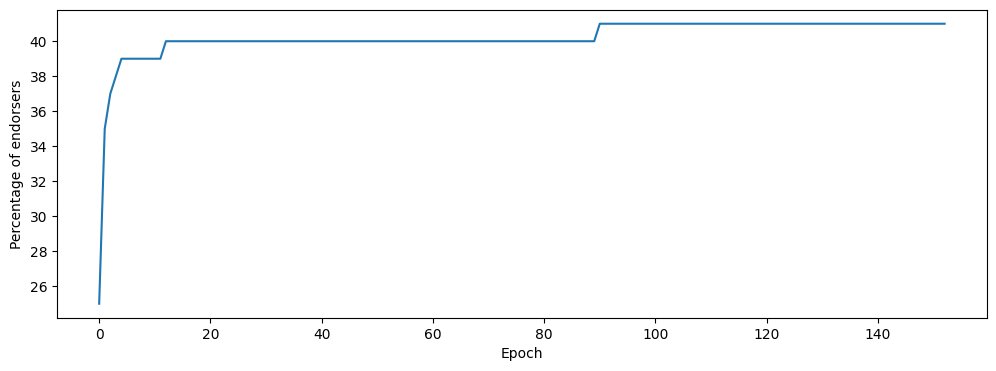

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(n_endorsers)
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [39]:
# cerco l'epoca in cui cominciano ad apparire i primi diffusori (in percentuale)
def find_first_nonzero_index(lst):
    for i, value in enumerate(lst):
        if value != 0:
            return i
    return None

index = find_first_nonzero_index(n_endorsers)
index

0

In [40]:
n_endorsers[index:]

[25,
 35,
 37,
 38,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41]

In [41]:
df = pd.DataFrame(n_endorsers[index:]).T

In [42]:
df

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
0,25,35,37,38,39,39,39,39,39,39,...,41,41,41,41,41,41,41,41,41,41


In [43]:
df.to_csv("palin_endorsers_days_percentage_list.csv", index=False, header=False)